Instantiate a ChromaDB database first.

In [3]:
import chromadb
path = "mm_vdb"
client = chromadb.PersistentClient(path=path)

Load a dataset from Huggingface. This is a dataset of 4000 images.

In [4]:
from datasets import load_dataset
ds = load_dataset("KoalaAI/StockImages-CC0")

Problematic images were identified at the indices indices_to_remove[]. They are manually removed through the code below. We get all indices, subtract indices to remove from it, then fetch all data where the index is in indices_to_keep[].

In [5]:
# Indices to remove
indices_to_remove = {586, 1002}

# Generate a list of indices excluding the problematic ones
all_indices = set(range(len(ds['train'])))
indices_to_keep = list(all_indices - indices_to_remove)
# Select the remaining entries in the dataset
ds['train'] = ds['train'].select(indices_to_keep)

# Verification
print(ds['train'])

Dataset({
    features: ['image', 'tags'],
    num_rows: 3997
})


Now, we save the images locally. Why do we do this? Input formats in many modules are expected in the format of a file path. Also, we can overcome temporary memory of sessions. Basically, saving images locally covers us on all fronts in the sense that it ensures the input, inspection and memory portions are secured in all cases. The enumerate() function in Python is a built-in function that adds a counter (an index) to an iterable and returns it as an enumerate object. Preprocessing of images is required because models often have specific input format requirements. Here, the process_and_save function basically gives a local file path to each image and saves it. We associate an index with the image for debugging and identification purposes. 

In [6]:
import os 
output_folder = "StockImages-cc0"
os.makedirs(output_folder, exist_ok=True)

def process_and_save_image(idx, item):
    try:
        image = item['image']
        image.save(os.path.join(output_folder, f"image_{idx}.jpg"))
    except Exception:
        pass

def process_images(dataset):
    for idx, item in enumerate(dataset['train']):
        process_and_save_image(idx, item)

# Running it
process_images(ds)

CLIP (Contrastive Language–Image Pretraining) is a model for generating embeddings. CLIP is widely used for multimodal tasks because it maps both text and image data into a shared embedding space. The embeddings generated by CLIP enable similarity search, classification, or retrieval tasks by representing images and text in the same vector space. Next, we look for a database with a certain name in ChromaDB. If it exists, we use it, else we create one with the specified name. We specify how the images must be pre-processed before embedding (through image_loader) and then what embedding function should be used (CLIP). This essentially creates a vector database in ChromaDB where both images and text are embedded in a shared vector space.

In [7]:
from chromadb.utils.data_loaders import ImageLoader
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

# Instantiate the Image Loader
image_loader = ImageLoader()
# Instantiate CLIP embeddings
CLIP = OpenCLIPEmbeddingFunction()

# Create the image collection
image_collection = client.get_or_create_collection(name="image_collection",
                                                   embedding_function = CLIP,
                                                   data_loader = image_loader)

Now that we have specified certain characteristics of an image collection, we can iterate over our locally saved file containing images and one by one add them to the collection. The id is like an index, while the uri points to the unique file path. The id is meant for internal organisation, while the uri helps identifying specific images for whatever reason. So, we have a unieuq id and a unique file path for each image to be added. This is the information we use in order to access the image while adding it to the image_collection.

In [ ]:
# Initialize lists for ids and uris
ids = []
uris = []

dataset_folder="StockImages-cc0"

# Iterate over each file in the dataset folder
for i, filename in enumerate(sorted(os.listdir(dataset_folder))):
    if filename.endswith('.jpg'):
        file_path = os.path.join(dataset_folder, filename)

        # Append id and uri to respective lists
        ids.append(str(i))
        uris.append(file_path)

# Add to image collection
image_collection.add(
    ids=ids,
    uris=uris
)

print("Images added to the database.")


Next, we test retreival based on similarity (distance) search. There is a function to display images based on a query. The display_images functions retrives a few results that are very similar to the query (close in vector space). Then, we find the uris (file paths) of these images and the distances (how similar they are to the query text). Then, we iterate over these, and with a check of satisfying max_distance criteria, we display the image using the Ipython.display display function. If working on debug mode, we print some additional info (file path of the image and its distance as computed by the vector embeddings).

URI: StockImages-cc0/image_2597.jpg - Distance: 1.4714200496673584


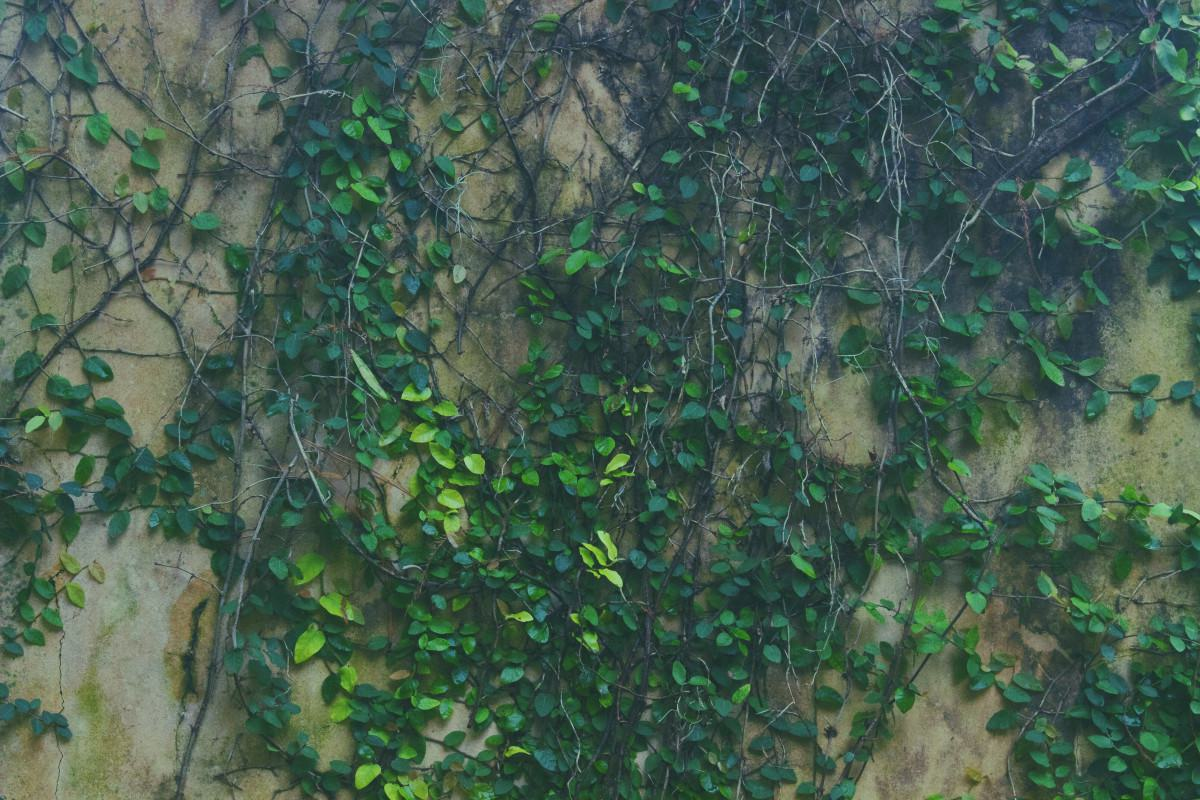

URI: StockImages-cc0/image_1473.jpg - Distance: 1.4885250329971313


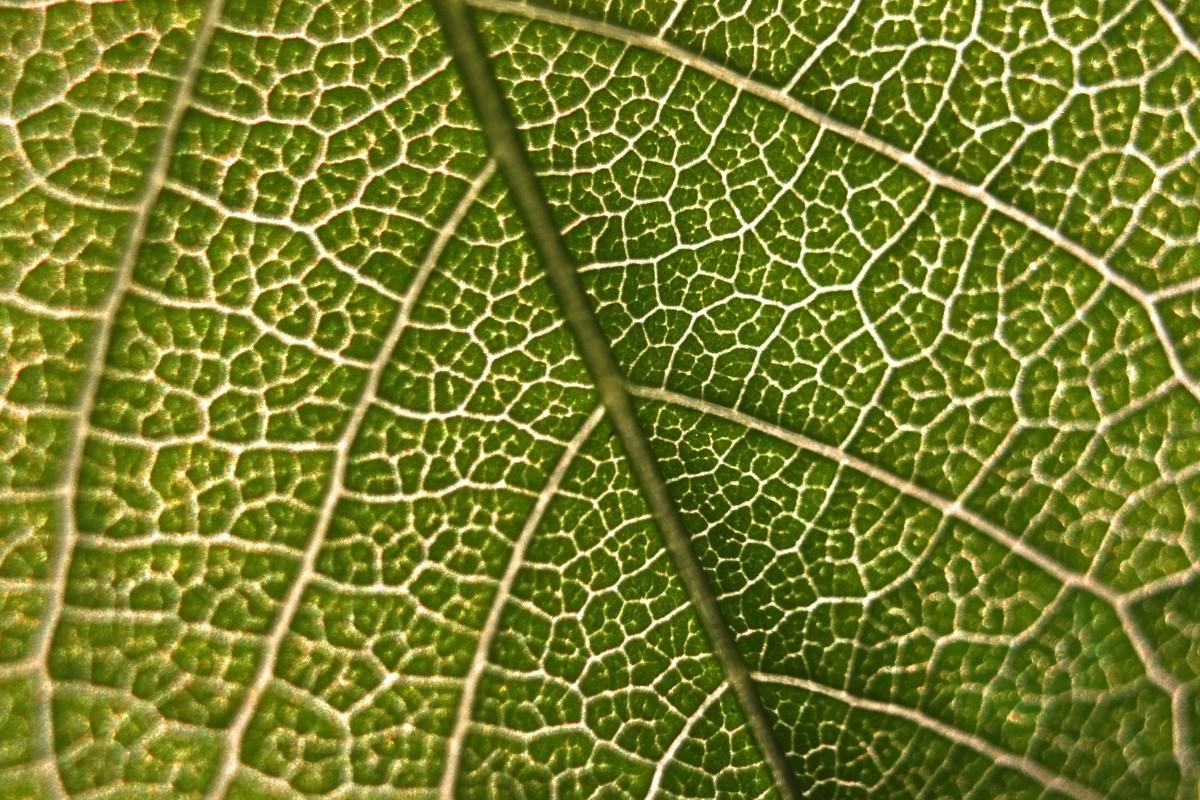

URI: StockImages-cc0/image_3060.jpg - Distance: 1.496996283531189


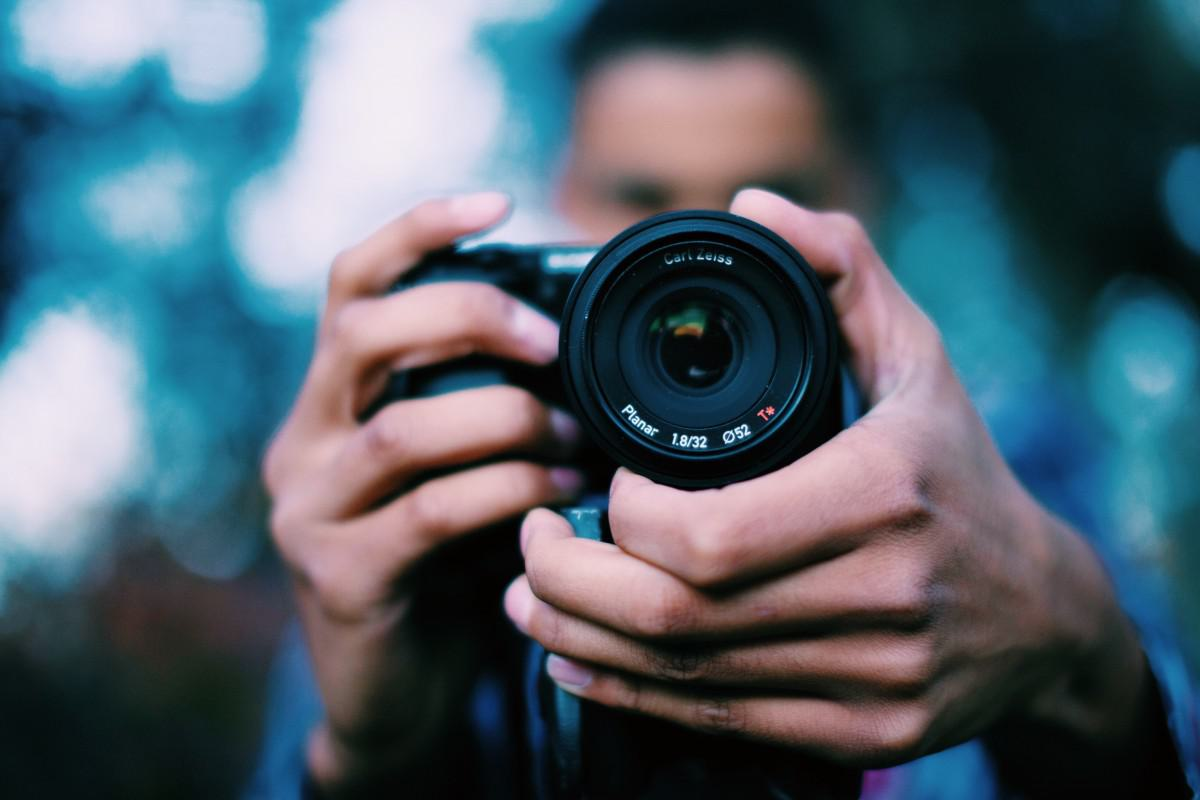

URI: StockImages-cc0/image_3567.jpg - Distance: 1.5031107664108276 (Filtered out)
URI: StockImages-cc0/image_506.jpg - Distance: 1.5034334659576416 (Filtered out)


In [12]:
from IPython.display import HTML, display, Image, Markdown, Video, Audio

def display_images(query_text, max_distance=None, debug=False):
    # Query the image collection with the specified text
    results = image_collection.query(
        query_texts=[query_text],
        n_results=5,
        include=['uris', 'distances']
    )

    # Extract uris and distances from the result
    uris = results['uris'][0]
    distances = results['distances'][0]

    # Display the images that meet the distance criteria
    for uri, distance in zip(uris, distances):
        # Check if a max_distance filter is applied and the distance is within the allowed range
        if max_distance is None or distance <= max_distance:
            if debug:
              print(f"URI: {uri} - Distance: {distance}")
            display(Image(uri, width=300))
        else:
            if debug:
              print(f"URI: {uri} - Distance: {distance} (Filtered out)")

# Running it
display_images("Grass", max_distance=1.5, debug=True)
